In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import ta
import gym
from gym import spaces
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from collections import deque
from torch.distributions import Normal


In [2]:
if torch.cuda.is_available():
    print("CUDA is available. PyTorch can use the GPU.")
else:
    print("CUDA is not available. PyTorch cannot use the GPU.")

CUDA is available. PyTorch can use the GPU.


In [3]:
# Download data
START_DATE = '2010-01-01'
END_DATE = '2020-12-31'
STOCKS = ['AAPL','TSLA', 'AMZN', 'GOOGL', 'MSFT', 'META','NVDA']

def download_data(tickers, start, end):
    data = {}
    for ticker in tickers:
        df = yf.download(ticker, start=start, end=end)
        df = df.dropna()
        data[ticker] = df
    return data
device = 'cuda'

data = download_data(STOCKS, START_DATE, END_DATE)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [4]:
# Add technical indicators
def add_technical_indicators(df):
    close = df['Close']
    
    # Ensure 'close' is a Series
    if isinstance(close, pd.DataFrame):
        close = close.squeeze()
    
    # Ensure 'close' is 1D
    if len(close.shape) > 1:
        close = close.flatten()
    
    # Compute indicators
    df['MA50'] = ta.trend.sma_indicator(close, window=50)
    df['MA200'] = ta.trend.sma_indicator(close, window=200)
    df['RSI'] = ta.momentum.RSIIndicator(close, window=14).rsi()
    df['MACD'] = ta.trend.MACD(close).macd()
    
    df = df.dropna()
    return df

for ticker in STOCKS:
    data[ticker] = add_technical_indicators(data[ticker])
    
print(data)    

{'AAPL': Price        Adj Close       Close        High         Low        Open  \
Ticker            AAPL        AAPL        AAPL        AAPL        AAPL   
Date                                                                     
2010-10-18    9.580285   11.357143   11.392857   11.224643   11.373929   
2010-10-19    9.323908   11.053214   11.206071   10.715000   10.835714   
2010-10-20    9.355240   11.090357   11.223214   10.959643   11.035714   
2010-10-21    9.324812   11.054286   11.240714   10.957143   11.155714   
2010-10-22    9.263053   10.981071   11.072857   10.939286   11.038214   
...                ...         ...         ...         ...         ...   
2020-12-23  128.059921  130.960007  132.429993  130.779999  132.160004   
2020-12-24  129.047531  131.970001  133.460007  131.100006  131.320007   
2020-12-28  133.662964  136.690002  137.339996  133.509995  133.990005   
2020-12-29  131.883286  134.869995  138.789993  134.339996  138.050003   
2020-12-30  130.758759  133.7

In [5]:
TRAIN_TEST_SPLIT = 0.8
for ticker in STOCKS:
    data[ticker] = add_technical_indicators(data[ticker])

train_data = {}
test_data = {}
for ticker in STOCKS:
    df = data[ticker]
    split_idx = int(len(df) * TRAIN_TEST_SPLIT)
    train_data[ticker] = df[:split_idx]
    test_data[ticker] = df[split_idx:]

In [6]:
class TradingEnv(gym.Env):
    def __init__(self, df, initial_balance=100000, window_size=60):
        super(TradingEnv, self).__init__()
        self.df = df.reset_index(drop=True)
        self.initial_balance = initial_balance
        self.window_size = window_size
        self.current_step = 0
        self.balance = initial_balance
        self.net_worth = initial_balance
        self.shares_held = 0
        self.max_steps = len(self.df) - window_size

        # Actions: Continuous value between -1 and 1
        # -1: Sell all shares
        # 0: Hold
        # 1: Buy maximum shares possible
        self.action_space = spaces.Box(low=-1, high=1, shape=(1,), dtype=np.float32)

        # Observation space
        self.observation_space = spaces.Box(
            low=-np.inf,
            high=np.inf,
            shape=(window_size, len(self.df.columns)),
            dtype=np.float32
        )

    def reset(self):
        self.balance = self.initial_balance
        self.net_worth = self.initial_balance
        self.shares_held = 0
        self.current_step = 0
        return self._next_observation()

    def _next_observation(self):
        frame = self.df.iloc[self.current_step:self.current_step + self.window_size]
        obs = frame.values
        # Normalize observations
        obs = (obs - obs.mean()) / (obs.std() + 1e-8)
        return obs.astype(np.float32)

    def step(self, action):
        # Ensure action is a scalar within [-1, 1]
        action = np.clip(action, -1, 1)[0]

        # Get current price
        current_price = float(self.df.iloc[self.current_step + self.window_size - 1]['Close'])
        prev_net_worth = self.net_worth

        # Calculate the amount to trade
        # Positive action: Buy, Negative action: Sell
        amount = action * self.initial_balance  # Scale action to initial balance
        shares_to_trade = amount / current_price

        # Execute trade
        if action > 0:
            # Buy shares
            max_shares_can_buy = self.balance / current_price
            shares_bought = min(max_shares_can_buy, shares_to_trade)
            cost = shares_bought * current_price
            self.balance -= cost
            self.shares_held += shares_bought
            shares_traded = shares_bought
        elif action < 0:
            # Sell shares
            shares_sold = min(self.shares_held, -shares_to_trade)
            self.balance += shares_sold * current_price
            self.shares_held -= shares_sold
            shares_traded = -shares_sold
        else:
            shares_traded = 0  # Hold

        # Update net worth
        self.net_worth = self.balance + self.shares_held * current_price

        # Calculate reward
        reward = self.net_worth - prev_net_worth

        # Transaction cost (e.g., 0.1% per trade)
        transaction_cost = 0.001 * current_price * abs(shares_traded)
        reward -= transaction_cost

        # Normalize reward
        reward /= self.initial_balance

        # Move to next timestep
        self.current_step += 1
        done = self.current_step >= self.max_steps

        # Get next observation
        obs = self._next_observation()

        return obs, reward, done, {}


    def render(self, mode='human'):
        profit = self.net_worth - self.initial_balance
        print(f'Step: {self.current_step}')
        print(f'Balance: {self.balance}')
        print(f'Shares held: {self.shares_held}')
        print(f'Net worth: {self.net_worth}')
        print(f'Profit: {profit}')

In [7]:
class ActorNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim, action_dim):
        super(ActorNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.mean = nn.Linear(hidden_dim, action_dim)
        self.log_std = nn.Parameter(torch.ones(action_dim) * -0.5)


    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        mean = self.mean(x)
        log_std = self.log_std.clamp(min=-20, max=2)
        std = torch.exp(self.log_std)
        return mean, std
    
class CriticNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(CriticNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.value = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        value = self.value(x)
        return value



In [8]:
class PPOContinuousAgent:
    def __init__(self, state_size, action_size, hidden_dim=64, actor_lr=3e-4, critic_lr=1e-3, gamma=0.99, clip_epsilon=0.2, update_timestep=2000, K_epochs=10, device='cpu'):
        self.state_size = state_size
        self.action_size = action_size
        self.gamma = gamma
        self.clip_epsilon = clip_epsilon
        self.update_timestep = update_timestep
        self.K_epochs = K_epochs
        self.device = torch.device(device)

        # Networks
        self.actor = ActorNetwork(state_size, hidden_dim, action_size).to(self.device)
        self.critic = CriticNetwork(state_size, hidden_dim).to(self.device)

        # Optimizers
        self.optimizer_actor = optim.Adam(self.actor.parameters(), lr=actor_lr)
        self.optimizer_critic = optim.Adam(self.critic.parameters(), lr=critic_lr)

        # Memory
        self.memory = []

        # Tracking variables
        self.timestep = 0

    def select_action(self, state):
        state = torch.FloatTensor(state).to(self.device)
        mean, std = self.actor(state)
        # Check for NaNs or Infs in mean and std
        if torch.isnan(mean).any() or torch.isinf(mean).any():
            print("Mean contains NaN or Inf values.")

        if torch.isnan(std).any() or torch.isinf(std).any():
            print("Std contains NaN or Inf values.")
        dist = Normal(mean, std)
        action = dist.sample()
        action = torch.clamp(action, -1, 1)  # Ensure action is within bounds
        log_prob = dist.log_prob(action).sum()
        return action.cpu().detach().numpy(), log_prob.item()

    def store_transition(self, state, action, log_prob, reward, next_state, done):
        self.memory.append((state, action, log_prob, reward, next_state, done))

    def compute_returns_and_advantages(self, rewards, masks, values):
        returns = []
        advantages = []
        gae = 0
        next_value = 0
        for step in reversed(range(len(rewards))):
            delta = rewards[step] + self.gamma * next_value * masks[step] - values[step]
            gae = delta + self.gamma * 0.95 * masks[step] * gae  # lambda=0.95
            advantages.insert(0, gae)
            next_value = values[step]
        returns = [adv + val for adv, val in zip(advantages, values)]
        return returns, advantages

    def update(self):
        # Convert memory to tensors
        states = torch.FloatTensor([m[0] for m in self.memory]).to(self.device)
        actions = torch.FloatTensor([m[1] for m in self.memory]).to(self.device)
        old_log_probs = torch.FloatTensor([m[2] for m in self.memory]).to(self.device)
        rewards = [m[3] for m in self.memory]
        dones = [0 if m[5] else 1 for m in self.memory]

        # Compute state values
        values = self.critic(states).detach().squeeze().cpu().numpy()

        # Compute returns and advantages
        returns, advantages = self.compute_returns_and_advantages(rewards, dones, values)

        returns = torch.FloatTensor(returns).to(self.device)
        advantages = torch.FloatTensor(advantages).to(self.device)
        # Normalize advantages
        adv_std = advantages.std()
        if adv_std == 0:
            adv_std = 1e-8
        advantages = (advantages - advantages.mean()) / adv_std

        # Optimize policy for K epochs
        for _ in range(self.K_epochs):
            # Recalculate distribution
            mean, std = self.actor(states)
            # Clamp std to prevent zero or negative values
            std = torch.clamp(std, min=1e-6)
            dist = Normal(mean, std)
            log_probs = dist.log_prob(actions).sum(axis=1)
            entropy = dist.entropy().sum(axis=1)

            # Ratios for clipping
            ratios = torch.exp(log_probs - old_log_probs)

            # Surrogate losses
            surr1 = ratios * advantages
            surr2 = torch.clamp(ratios, 1 - self.clip_epsilon, 1 + self.clip_epsilon) * advantages

            # Actor loss
            actor_loss = -torch.min(surr1, surr2).mean()

            # Critic loss
            values_pred = self.critic(states).squeeze()
            critic_loss = nn.MSELoss()(values_pred, returns)

            # Total loss
            loss = actor_loss + 0.5 * critic_loss - 0.01 * entropy.mean()

            # Update networks
            self.optimizer_actor.zero_grad()
            self.optimizer_critic.zero_grad()
            loss.backward()

            # Clip gradients
            max_grad_norm = 0.5
            nn.utils.clip_grad_norm_(self.actor.parameters(), max_grad_norm)
            nn.utils.clip_grad_norm_(self.critic.parameters(), max_grad_norm)

            self.optimizer_actor.step()
            self.optimizer_critic.step()

        # Clear memory
        self.memory = []


In [9]:
def train_ppo_continuous_agent(env, agent, max_timesteps, log_interval):
    timestep = 0
    episode = 0
    rewards_history = []

    while timestep < max_timesteps:
        state = env.reset()
        state_flat = state.flatten()
        done = False
        episode_reward = 0

        while not done:
            # Select action
            action, log_prob = agent.select_action(state_flat)
            next_state, reward, done, _ = env.step(action)
            next_state_flat = next_state.flatten()

            # Store transition
            agent.store_transition(state_flat, action, log_prob, reward, next_state_flat, done)

            state_flat = next_state_flat
            episode_reward += reward
            timestep += 1
            agent.timestep += 1

            # Update PPO agent
            if agent.timestep % agent.update_timestep == 0:
                agent.update()
                agent.timestep = 0

            if timestep >= max_timesteps:
                break

        episode += 1
        rewards_history.append(episode_reward)

        if episode % log_interval == 0:
            avg_reward = np.mean(rewards_history[-log_interval:])
            print(f"Episode {episode}, Average Reward: {avg_reward:.2f}")

    return rewards_history


In [10]:
def test_ppo_continuous_agent(env, agent):
    state = env.reset()
    done = False
    total_reward = 0
    net_worths = []
    actions = []
    prices = []
    steps = []
    balances = []
    shares_helds = []

    while not done:
        state_flat = state.flatten()
        # Select action
        state_tensor = torch.FloatTensor(state_flat).to(agent.device)
        with torch.no_grad():
            mean, std = agent.actor(state_tensor)
            dist = Normal(mean, std)
            action = dist.mean  # Use mean action for testing
            action = torch.clamp(action, -1, 1)
        action = action.cpu().numpy()
        next_state, reward, done, _ = env.step(action)
        next_state_flat = next_state.flatten()

        # Record data
        net_worths.append(env.net_worth)
        actions.append(action[0])
        current_price = float(env.df.iloc[env.current_step + env.window_size - 1]['Close'])
        prices.append(current_price)
        steps.append(env.current_step)
        balances.append(env.balance)
        shares_helds.append(env.shares_held)

        state = next_state
        total_reward += reward

    print(f"Test completed. Total Reward: {total_reward}")
    return net_worths, actions, prices, steps, balances, shares_helds


In [11]:
def plot_test_performance_ddpg(net_worths, actions, prices, steps):
    # Plot Net Worth Over Time
    plt.figure(figsize=(14,7))
    plt.subplot(2,1,1)
    plt.plot(steps, net_worths, label='Agent Net Worth')
    plt.xlabel('Time Steps')
    plt.ylabel('Net Worth ($)')
    plt.title('Agent Net Worth Over Time')
    plt.legend()

    # Plot Actions Over Time
    plt.subplot(2,1,2)
    plt.plot(steps, prices, label='Stock Price')
    # Actions as color map
    sc = plt.scatter(steps, prices, c=actions, cmap='coolwarm', label='Actions')
    plt.colorbar(sc, label='Action Value (-1 to 1)')
    plt.xlabel('Time Steps')
    plt.ylabel('Stock Price ($)')
    plt.title('Agent Actions Over Time')
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_cumulative_returns(net_worths, env):
    initial_balance = env.initial_balance
    agent_returns = np.array(net_worths) / initial_balance - 1
    
    # Buy-and-hold returns
    initial_price = float(env.df.iloc[env.window_size - 1]['Close'])
    final_prices = env.df['Close'].values[env.window_size - 1:]
    buy_and_hold_returns = final_prices / initial_price - 1
    
    # Ensure the lengths match
    min_length = min(len(agent_returns), len(buy_and_hold_returns))
    agent_returns = agent_returns[:min_length]
    buy_and_hold_returns = buy_and_hold_returns[:min_length]
    
    plt.figure(figsize=(12,6))
    plt.plot(agent_returns, label='Agent Strategy')
    plt.plot(buy_and_hold_returns, label='Buy and Hold Strategy')
    plt.xlabel('Time Steps')
    plt.ylabel('Cumulative Returns')
    plt.title('Cumulative Returns Comparison')
    plt.legend()
    plt.show()


def plot_portfolio_components(net_worths, balances, equity_values):
    plt.figure(figsize=(12,6))
    plt.plot(balances, label='Cash Balance')
    plt.plot(equity_values, label='Equity Value')
    plt.plot(net_worths, label='Total Net Worth')
    plt.xlabel('Time Steps')
    plt.ylabel('Value ($)')
    plt.title('Portfolio Components Over Time')
    plt.legend()
    plt.show()


def plot_test_performance(net_worths, actions, prices, steps):
    # Plot Net Worth Over Time
    plt.figure(figsize=(14,7))
    plt.subplot(2,1,1)
    plt.plot(steps, net_worths, label='Agent Net Worth')
    plt.xlabel('Time Steps')
    plt.ylabel('Net Worth ($)')
    plt.title('Agent Net Worth Over Time')
    plt.legend()
    
    # Plot Actions Over Time
    plt.subplot(2,1,2)
    plt.plot(steps, prices, label='Stock Price')
    
    # Define action categories based on the new action space
    buy_actions = [1, 2, 3]
    sell_actions = [4, 5, 6]
    hold_actions = [0]
    
    # Map actions to percentages for labeling
    action_labels = {
        1: 'Buy 10%',
        2: 'Buy 50%',
        3: 'Buy 100%',
        4: 'Sell 10%',
        5: 'Sell 50%',
        6: 'Sell 100%',
    }
    
    # Plot buy actions
    for action in buy_actions:
        action_steps = [s for s, a in zip(steps, actions) if a == action]
        action_prices = [prices[i - steps[0]] for i in action_steps]
        plt.scatter(action_steps, action_prices, marker='^', label=action_labels[action])
    
    # Plot sell actions
    for action in sell_actions:
        action_steps = [s for s, a in zip(steps, actions) if a == action]
        action_prices = [prices[i - steps[0]] for i in action_steps]
        plt.scatter(action_steps, action_prices, marker='v', label=action_labels[action])
    
    plt.xlabel('Time Steps')
    plt.ylabel('Stock Price ($)')
    plt.title('Agent Actions Over Time')
    plt.legend()
    plt.tight_layout()
    plt.show()


def compute_buy_and_hold(env):
    initial_balance = env.initial_balance
    initial_price = float(env.df.iloc[env.window_size - 1]['Close'])
    final_price = float(env.df.iloc[-1]['Close'])
    shares = initial_balance // initial_price
    remaining_balance = initial_balance - shares * initial_price
    final_net_worth = remaining_balance + shares * final_price
    return final_net_worth


def compute_performance_metrics(net_worths):
    net_worths = np.array(net_worths)
    returns = np.diff(net_worths) / net_worths[:-1]
    total_return = (net_worths[-1] - net_worths[0]) / net_worths[0]
    annualized_return = total_return * (252 / len(net_worths))  # Assuming daily data

    # Sharpe Ratio
    risk_free_rate = 0.0  # Assuming zero risk-free rate
    if np.std(returns) != 0:
        sharpe_ratio = (np.mean(returns) - risk_free_rate) / np.std(returns) * np.sqrt(252)
    else:
        sharpe_ratio = 0.0  # Avoid division by zero

    # Maximum Drawdown
    cumulative_returns = net_worths / net_worths[0]
    running_max = np.maximum.accumulate(cumulative_returns)
    drawdowns = (running_max - cumulative_returns) / running_max
    max_drawdown = np.max(drawdowns)

    print(f"Total Return: {total_return * 100:.2f}%")
    print(f"Annualized Return: {annualized_return * 100:.2f}%")
    print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
    print(f"Maximum Drawdown: {max_drawdown * 100:.2f}%")


Training PPO Continuous agent for AAPL


C:\Users\yang1\AppData\Local\Temp\ipykernel_18108\3817249791.py:46: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  current_price = float(self.df.iloc[self.current_step + self.window_size - 1]['Close'])
C:\Users\yang1\AppData\Local\Temp\ipykernel_18108\2569866409.py:58: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  states = torch.FloatTensor([m[0] for m in self.memory]).to(self.device)


Episode 10, Average Reward: 0.14
Episode 20, Average Reward: 0.31
Trained PPO Continuous agent for AAPL saved.


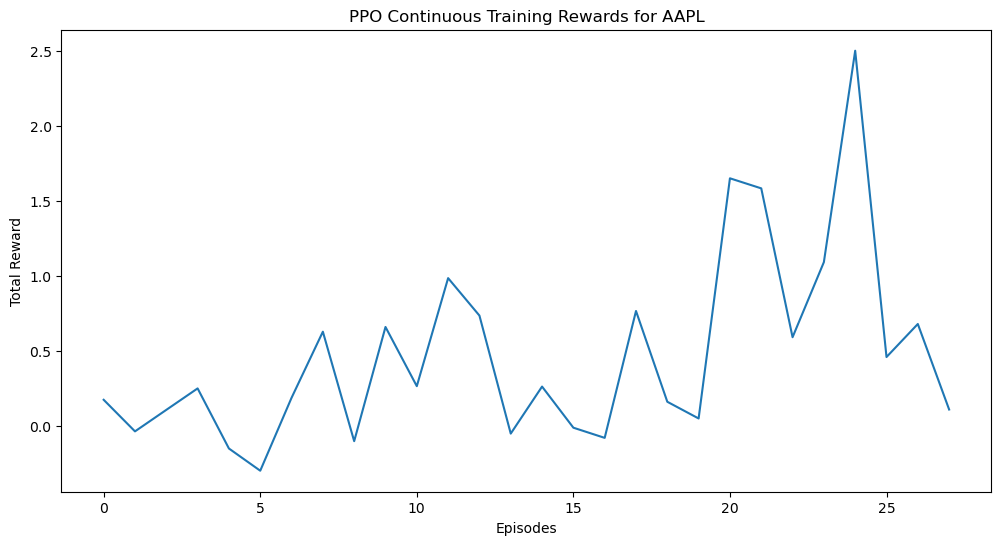


Testing PPO Continuous agent for AAPL


C:\Users\yang1\AppData\Local\Temp\ipykernel_18108\2822420314.py:28: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  current_price = float(env.df.iloc[env.current_step + env.window_size - 1]['Close'])


Test completed. Total Reward: 1.8911802368844068


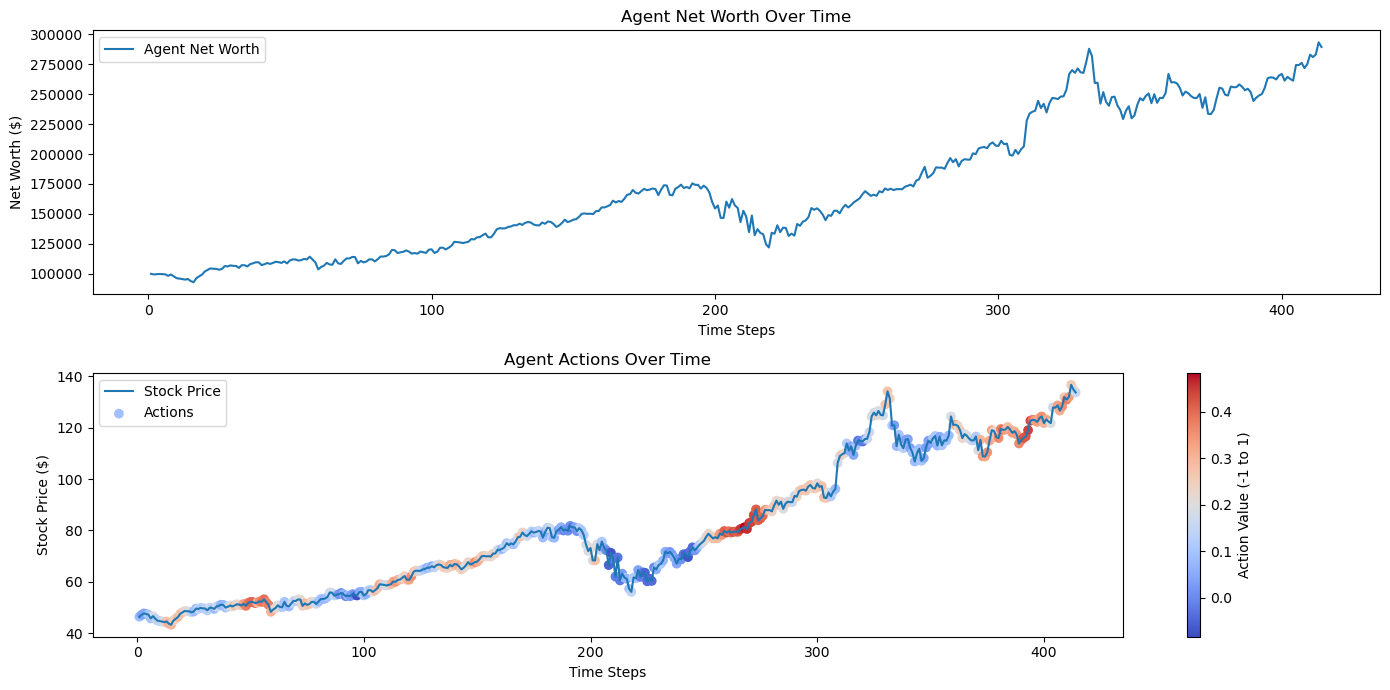

Total Return: 189.39%
Annualized Return: 115.28%
Sharpe Ratio: 1.91
Maximum Drawdown: 30.49%


C:\Users\yang1\AppData\Local\Temp\ipykernel_18108\1716556858.py:29: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  initial_price = float(env.df.iloc[env.window_size - 1]['Close'])


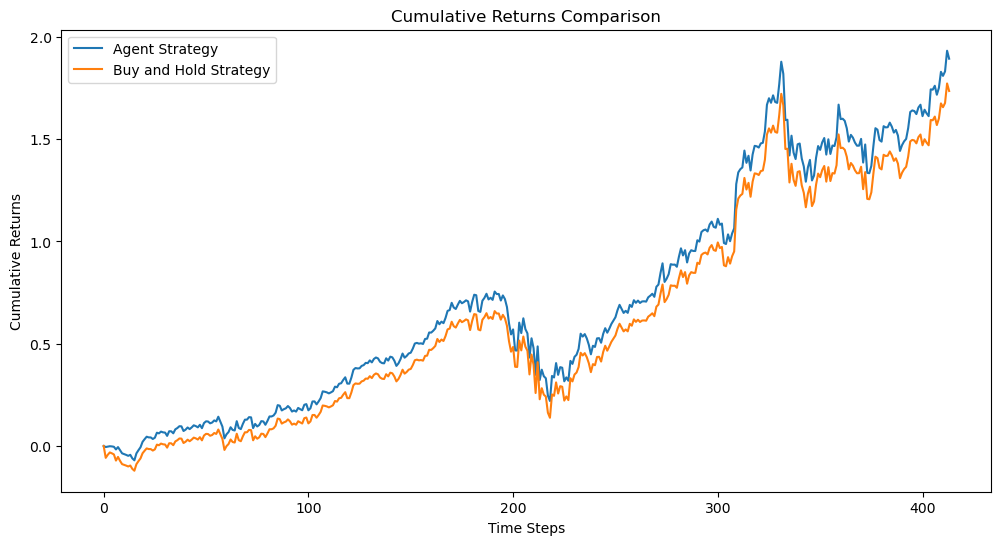

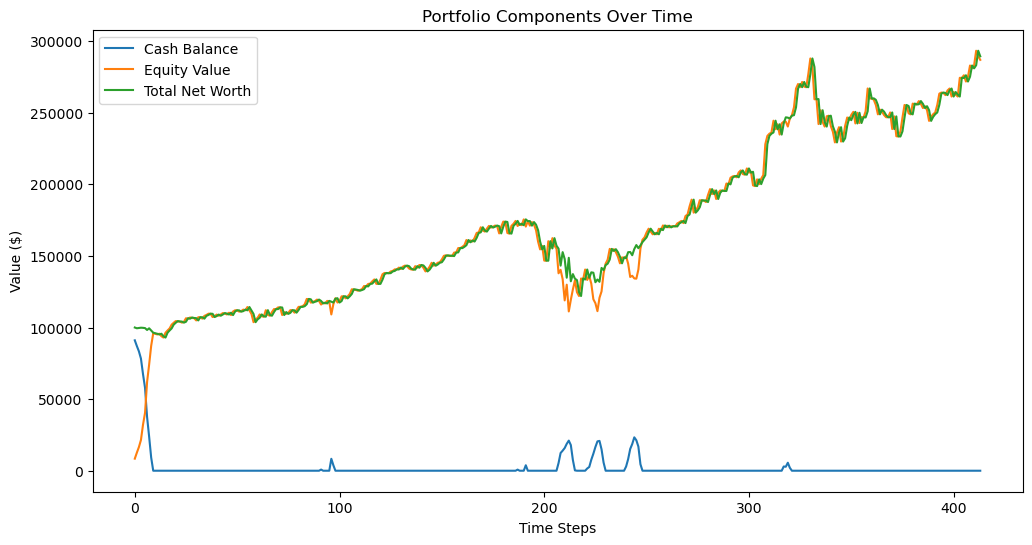


Training PPO Continuous agent for TSLA
Episode 10, Average Reward: 4.91
Episode 20, Average Reward: 5.84
Trained PPO Continuous agent for TSLA saved.


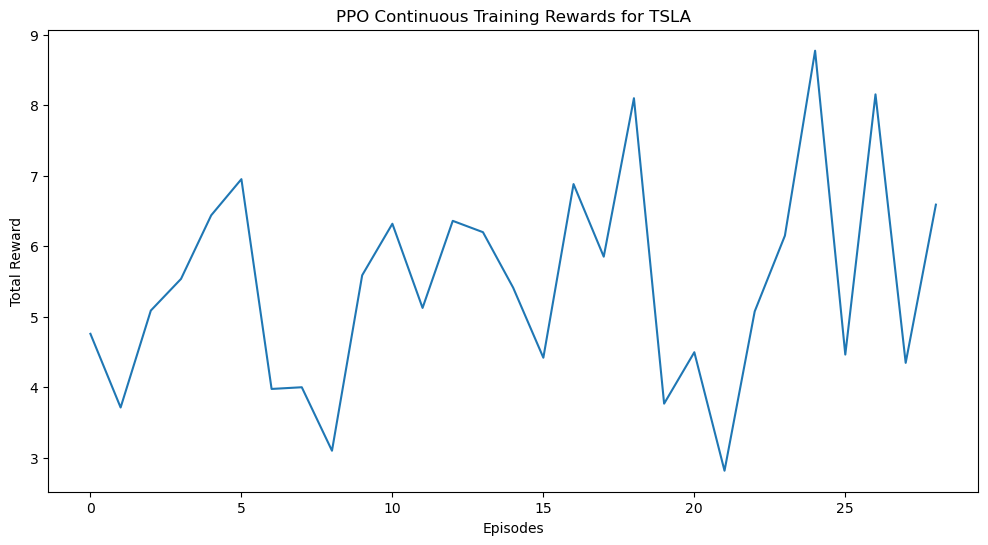


Testing PPO Continuous agent for TSLA
Test completed. Total Reward: 11.403772473053717


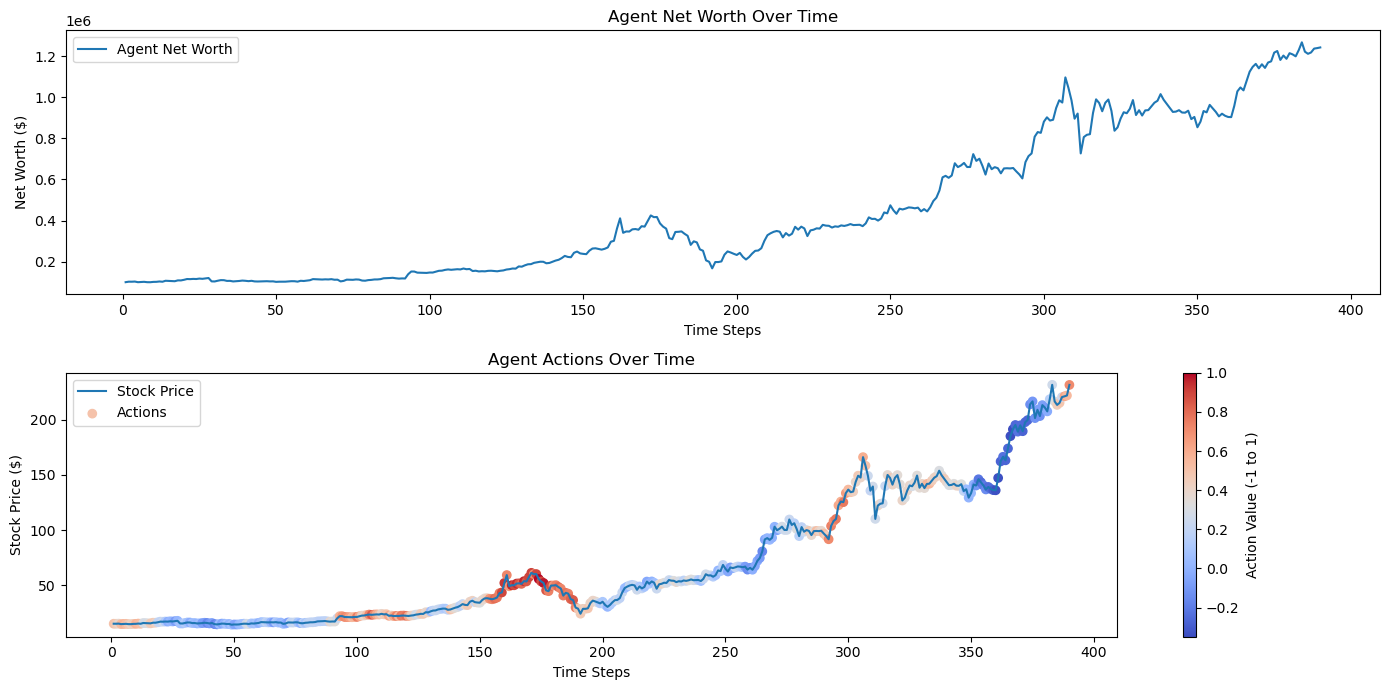

Total Return: 1141.93%
Annualized Return: 737.86%
Sharpe Ratio: 2.56
Maximum Drawdown: 60.63%


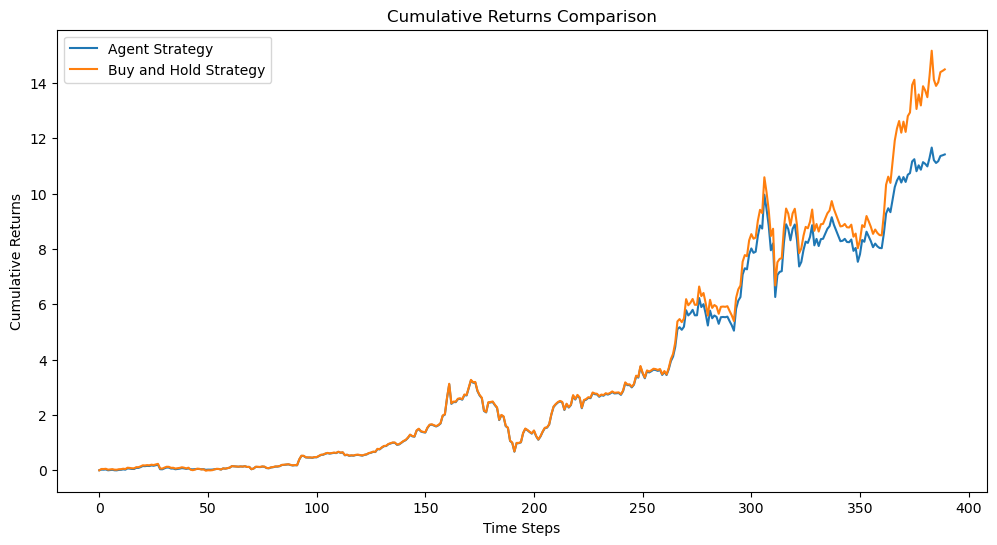

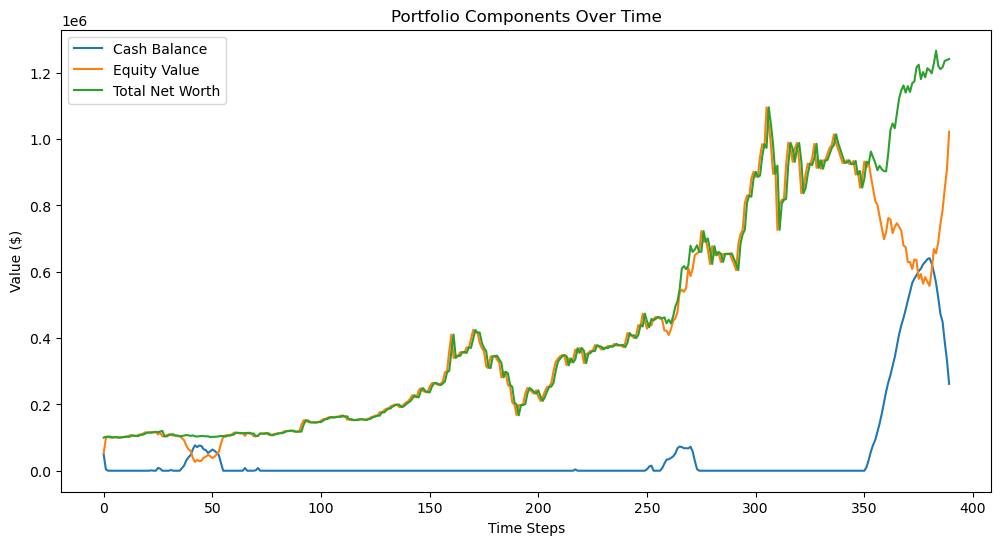


Training PPO Continuous agent for AMZN
Episode 10, Average Reward: 4.16
Episode 20, Average Reward: 5.68
Trained PPO Continuous agent for AMZN saved.


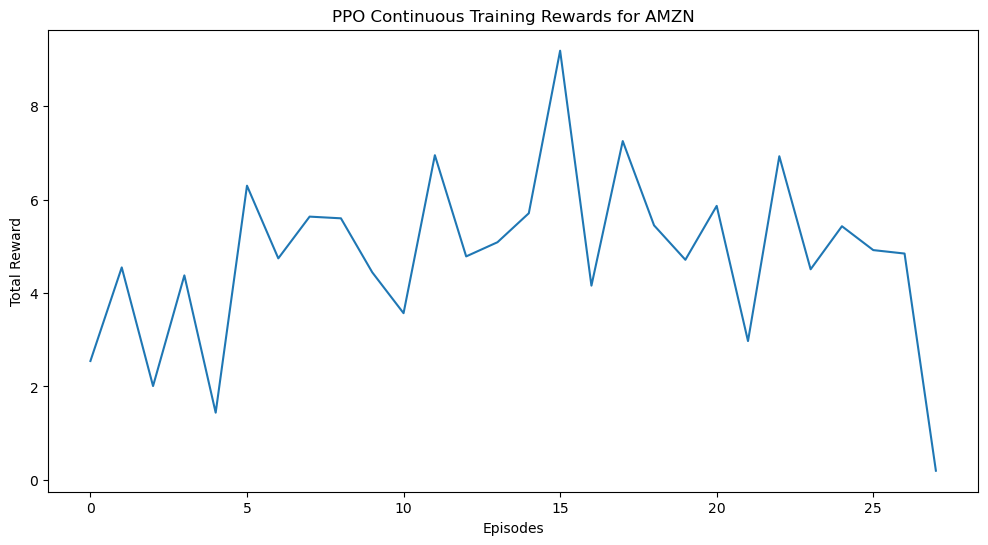


Testing PPO Continuous agent for AMZN
Test completed. Total Reward: 0.7762774839716029


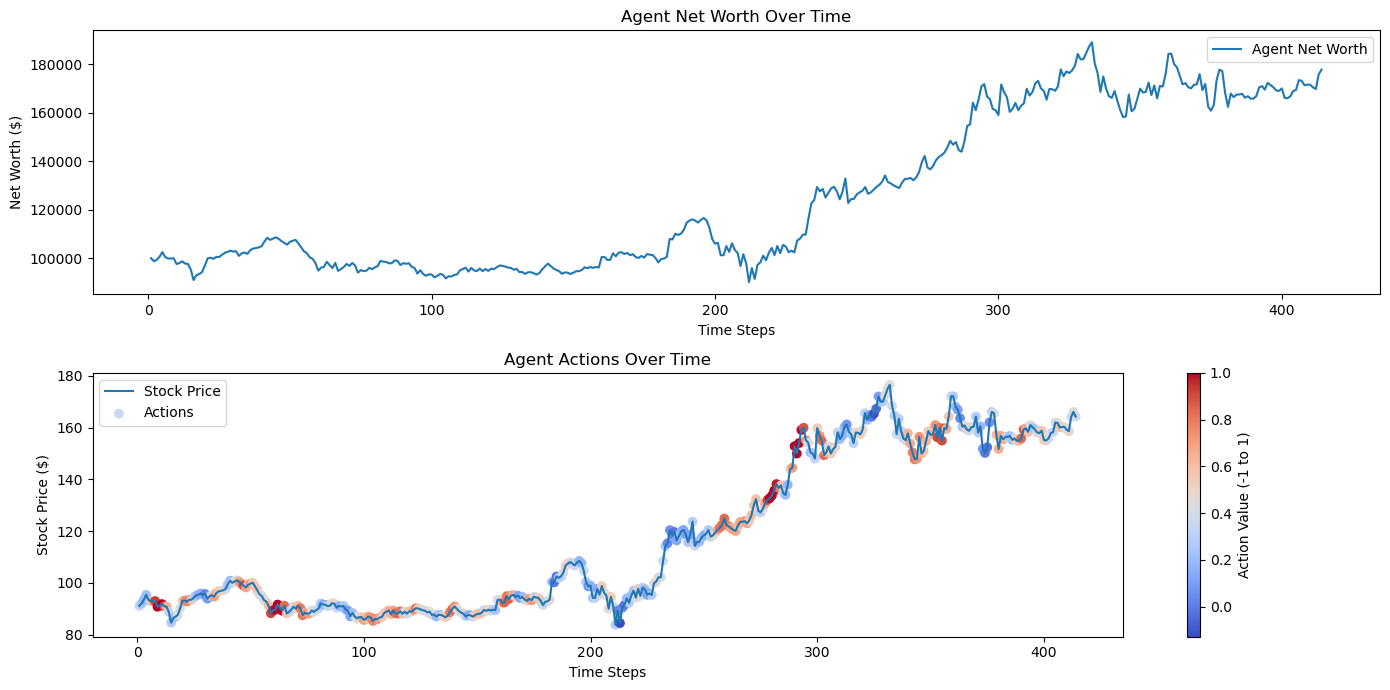

Total Return: 77.81%
Annualized Return: 47.36%
Sharpe Ratio: 1.25
Maximum Drawdown: 22.74%


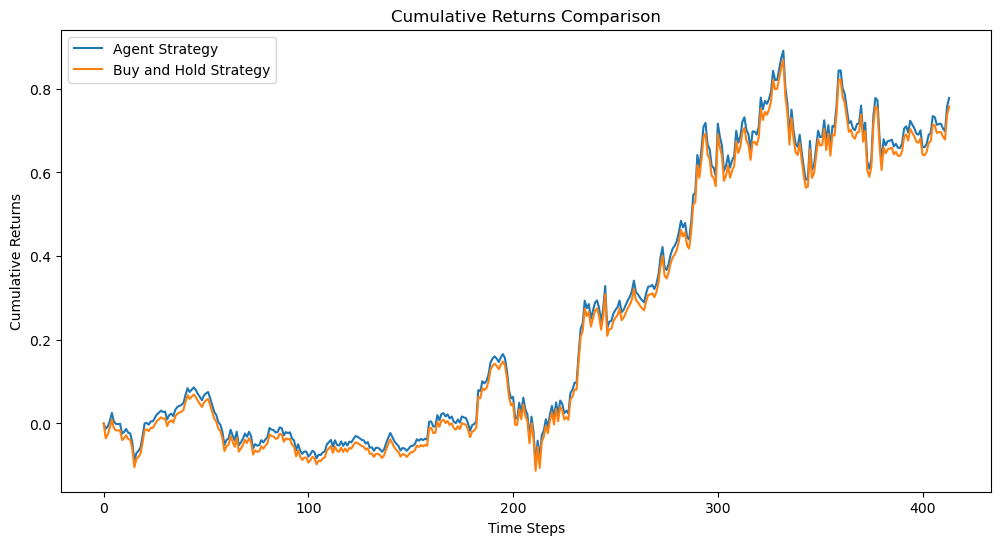

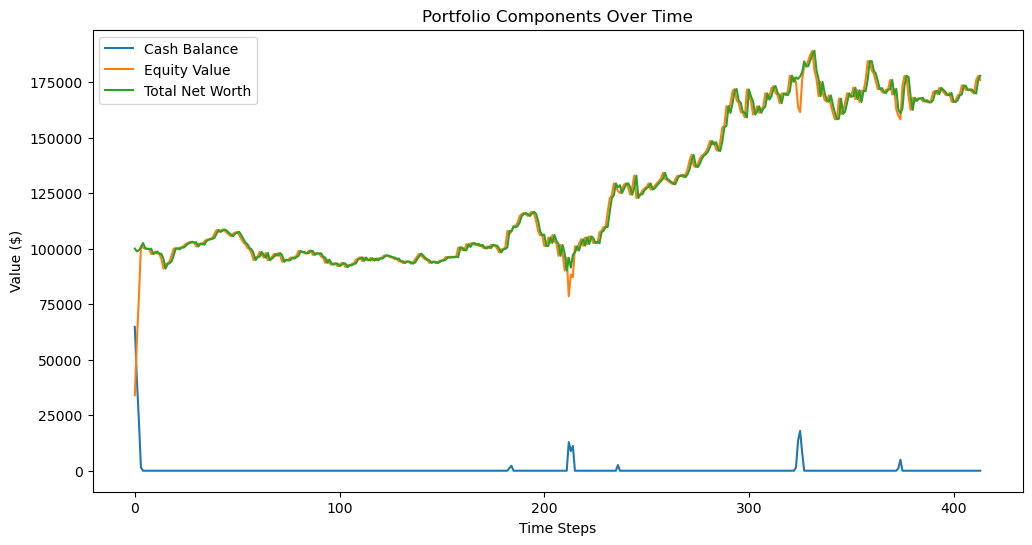


Training PPO Continuous agent for GOOGL
Episode 10, Average Reward: 1.28
Episode 20, Average Reward: 2.14
Trained PPO Continuous agent for GOOGL saved.


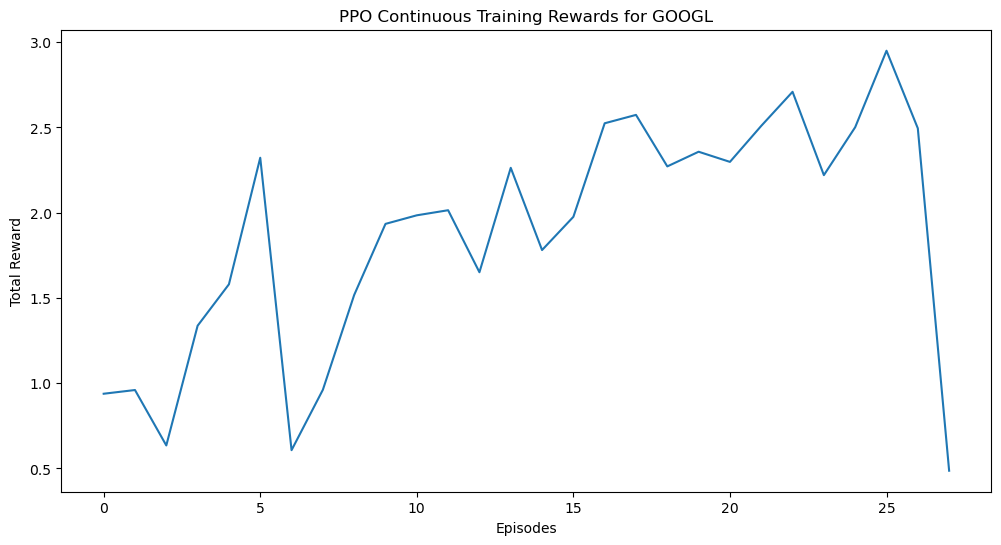


Testing PPO Continuous agent for GOOGL
Test completed. Total Reward: 0.5198236601823161


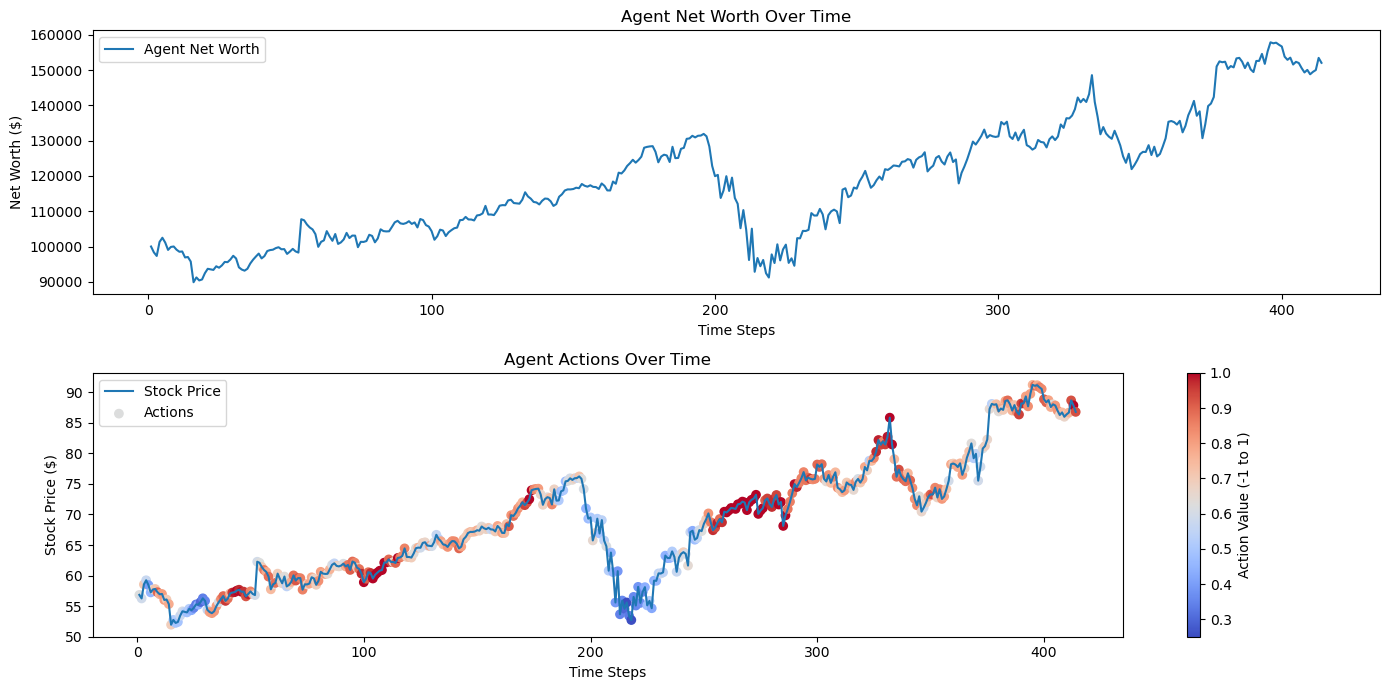

Total Return: 52.08%
Annualized Return: 31.70%
Sharpe Ratio: 0.94
Maximum Drawdown: 30.87%


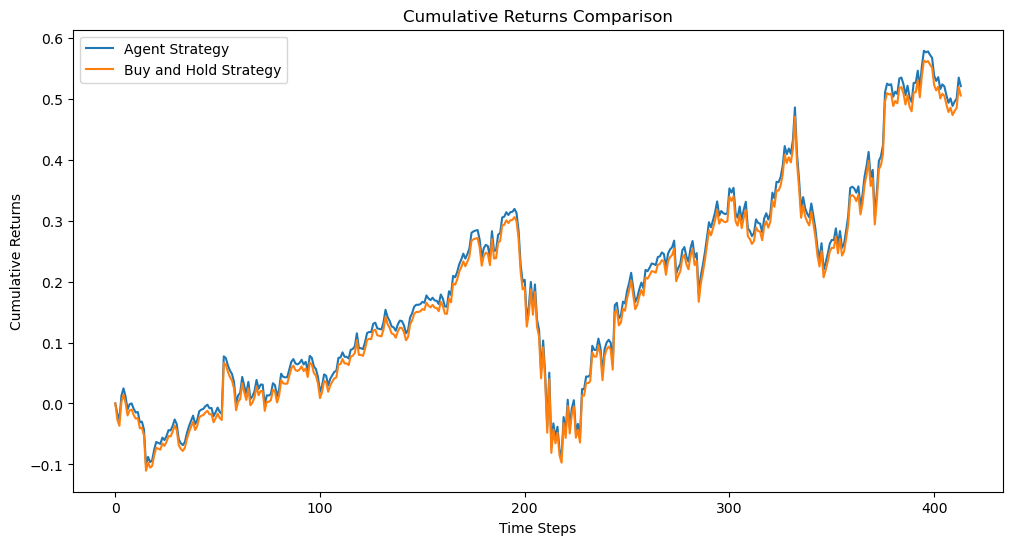

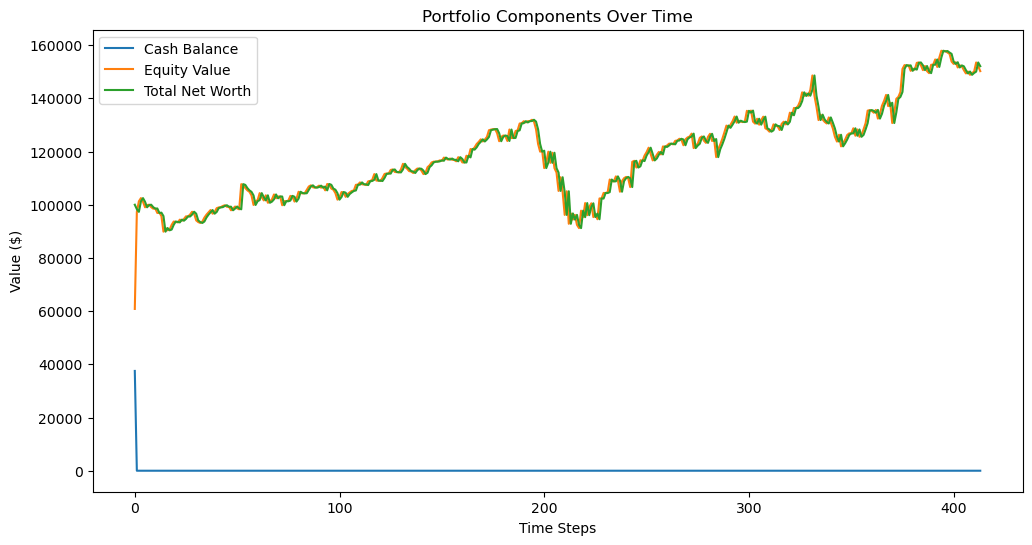


Training PPO Continuous agent for MSFT
Episode 10, Average Reward: 0.65
Episode 20, Average Reward: 1.30
Trained PPO Continuous agent for MSFT saved.


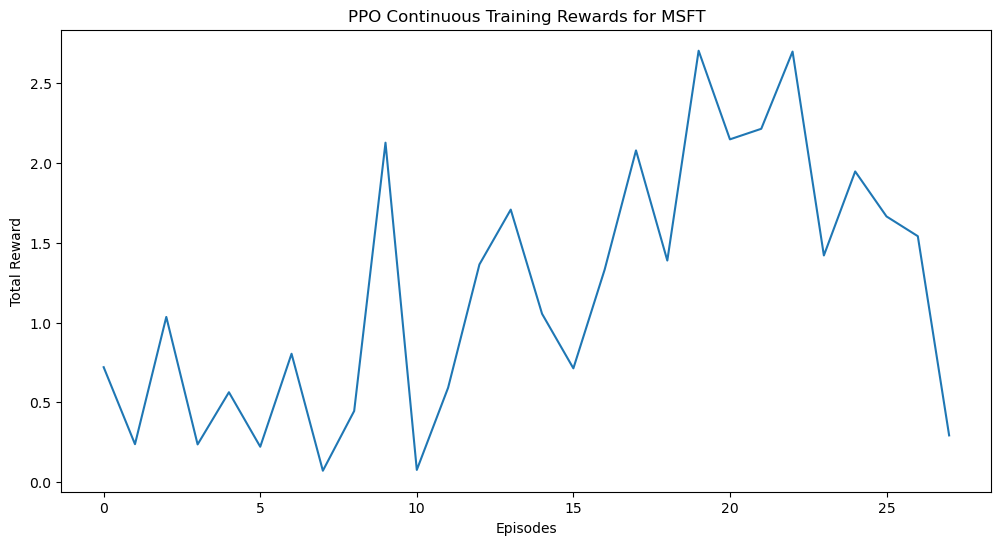


Testing PPO Continuous agent for MSFT
Test completed. Total Reward: 0.7915647481142466


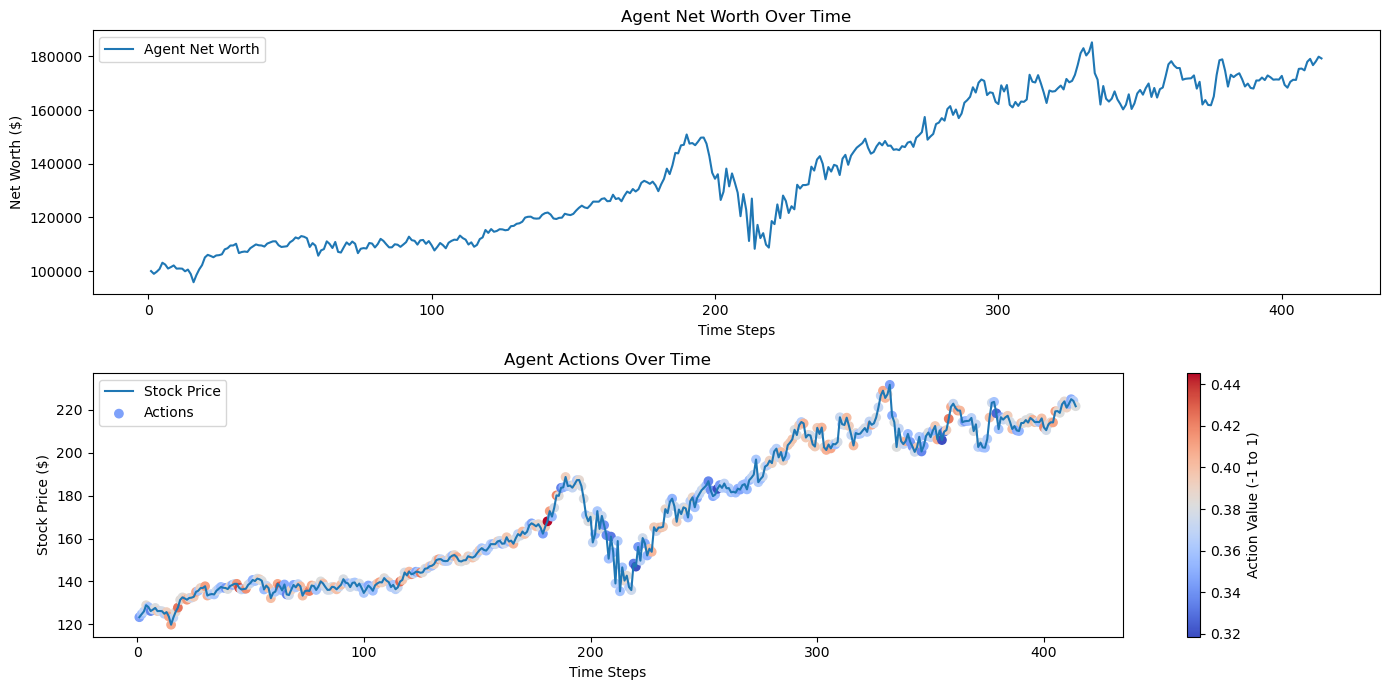

Total Return: 79.26%
Annualized Return: 48.24%
Sharpe Ratio: 1.17
Maximum Drawdown: 28.24%


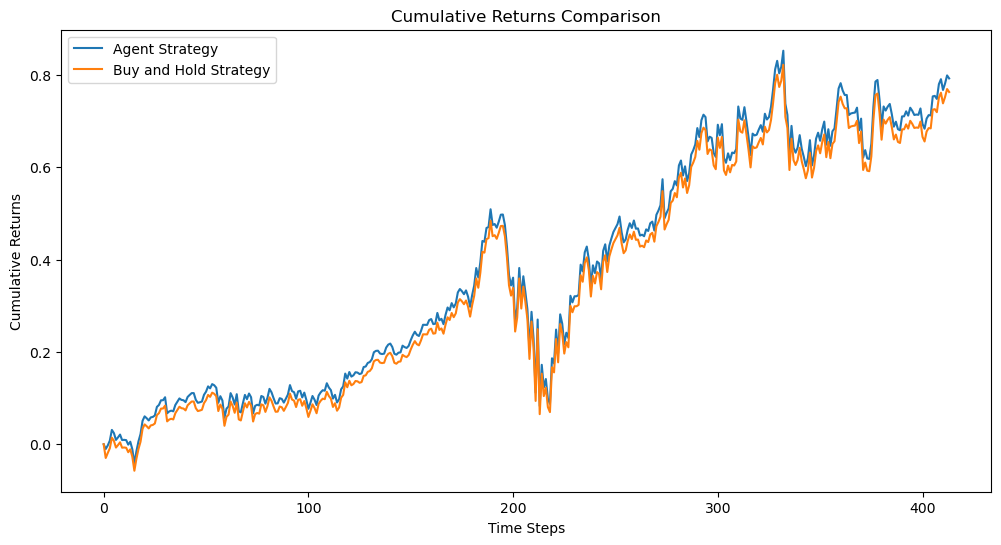

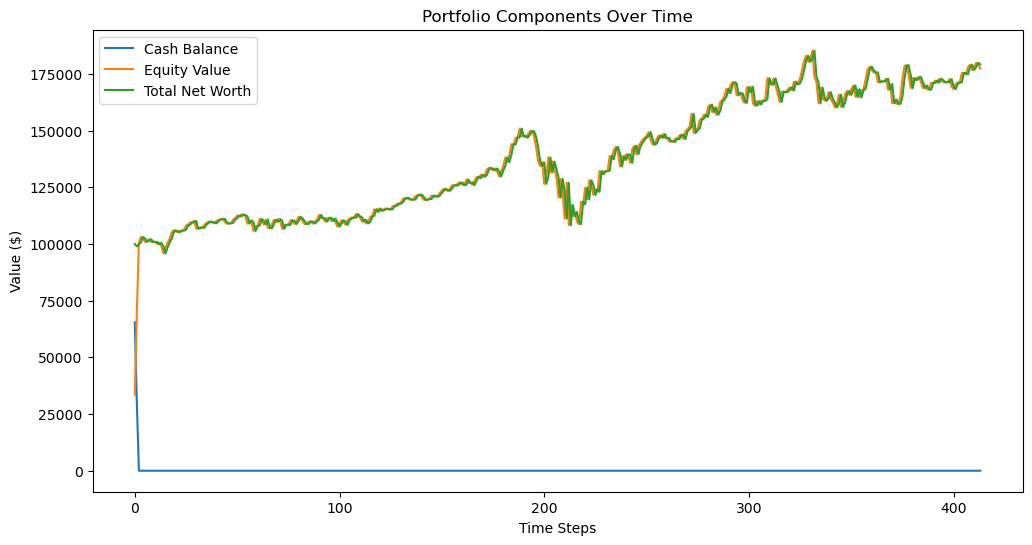


Training PPO Continuous agent for META
Episode 10, Average Reward: 0.34
Episode 20, Average Reward: 0.59
Episode 30, Average Reward: 1.01
Trained PPO Continuous agent for META saved.


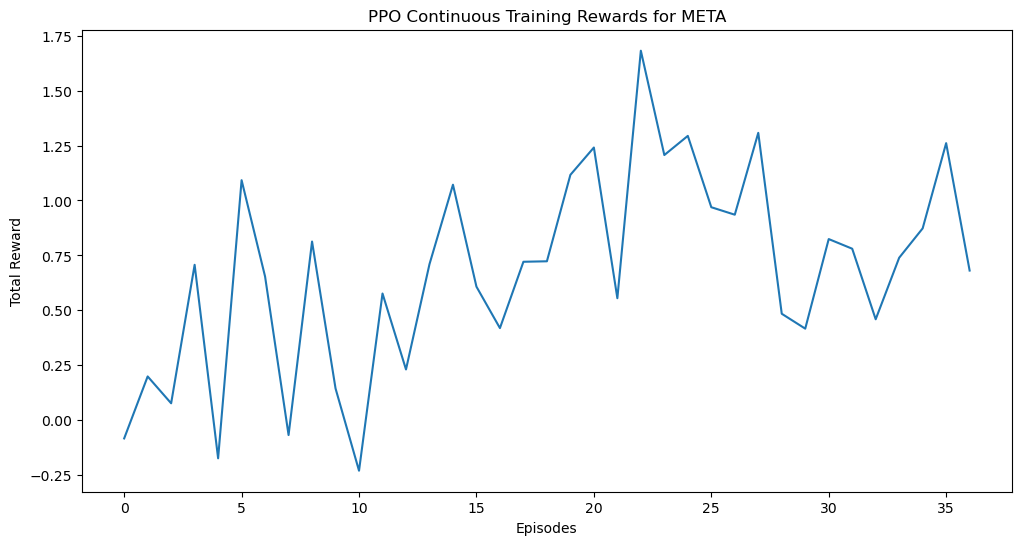


Testing PPO Continuous agent for META
Test completed. Total Reward: 0.464046258834349


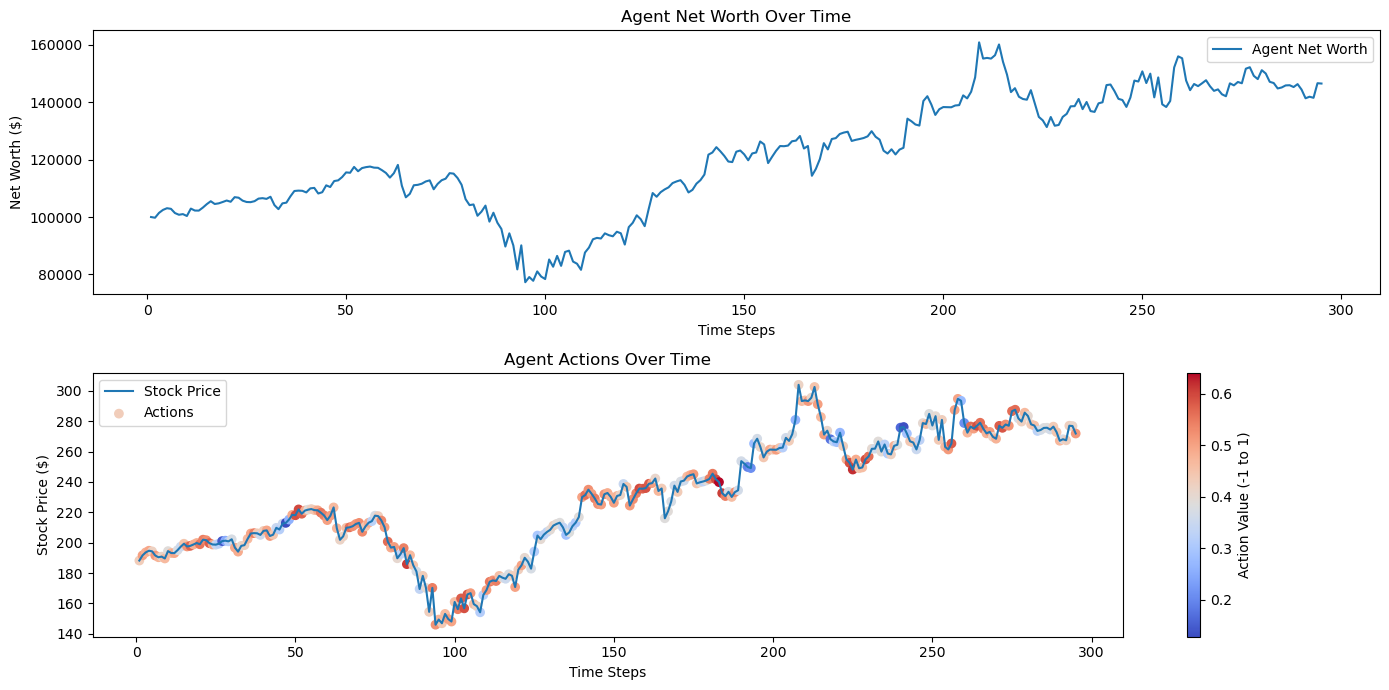

Total Return: 46.50%
Annualized Return: 39.73%
Sharpe Ratio: 0.98
Maximum Drawdown: 34.59%


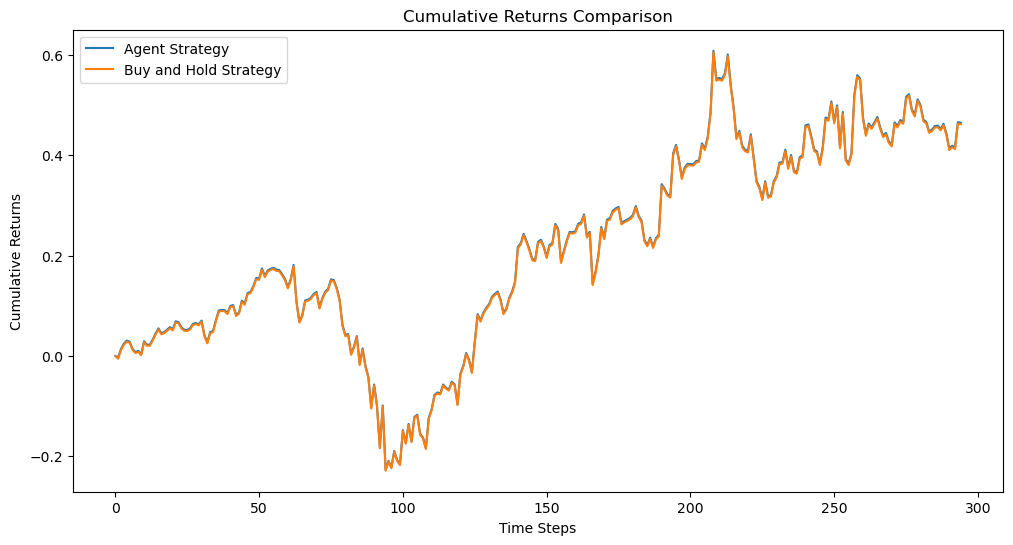

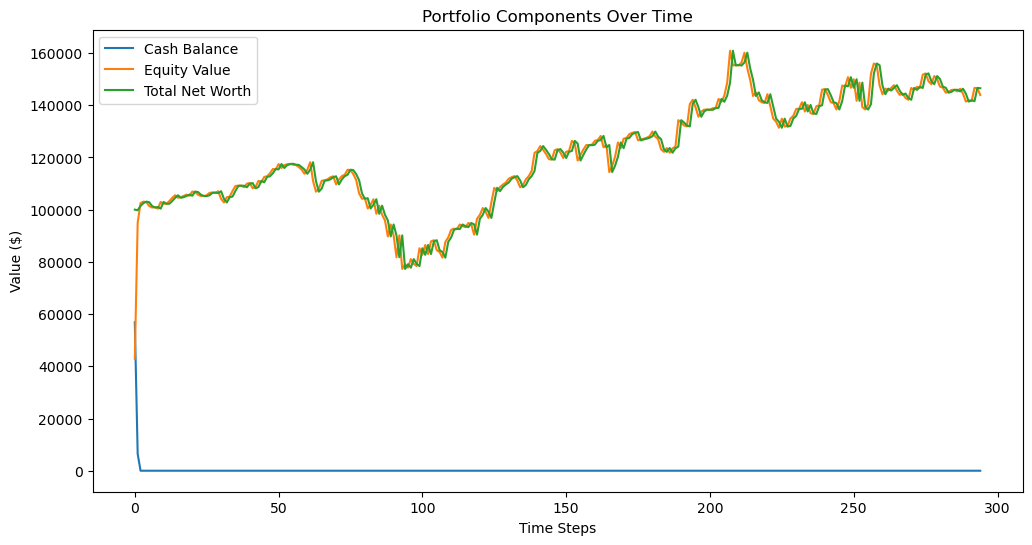


Training PPO Continuous agent for NVDA
Episode 10, Average Reward: 5.66
Episode 20, Average Reward: 8.19
Trained PPO Continuous agent for NVDA saved.


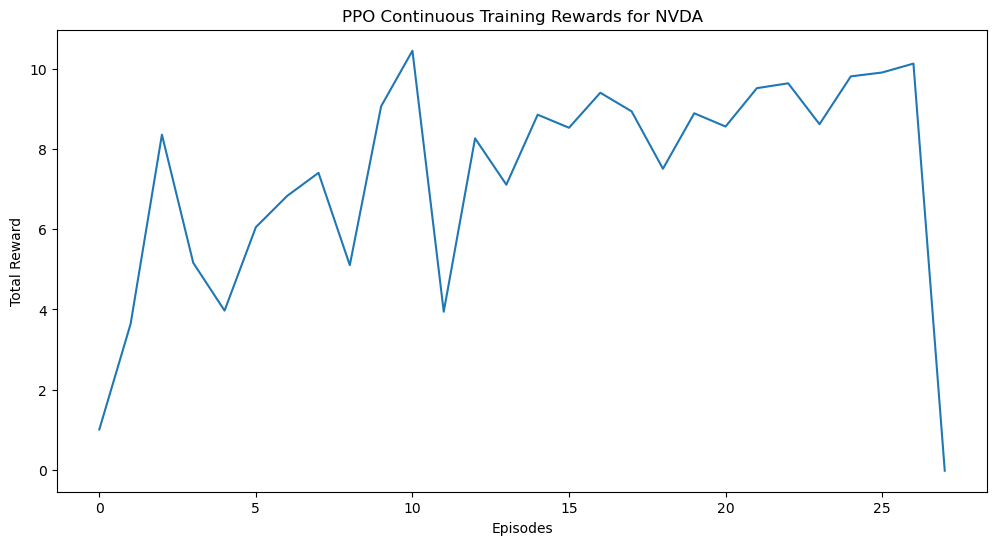


Testing PPO Continuous agent for NVDA
Test completed. Total Reward: 2.0860521515513035


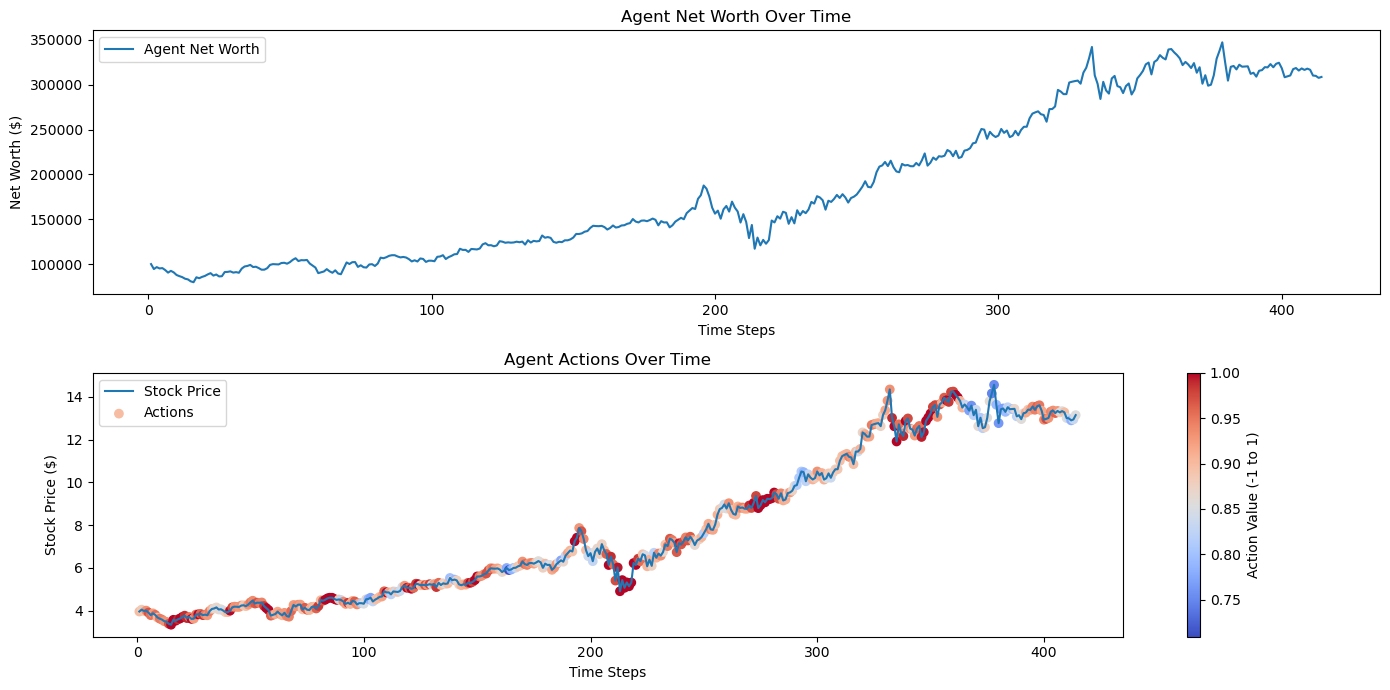

Total Return: 208.71%
Annualized Return: 127.04%
Sharpe Ratio: 1.61
Maximum Drawdown: 37.59%


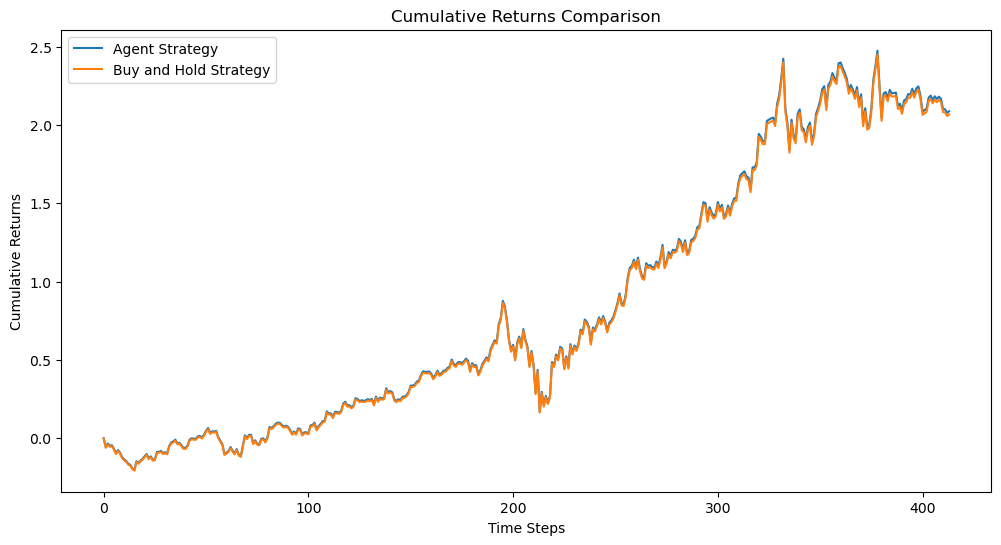

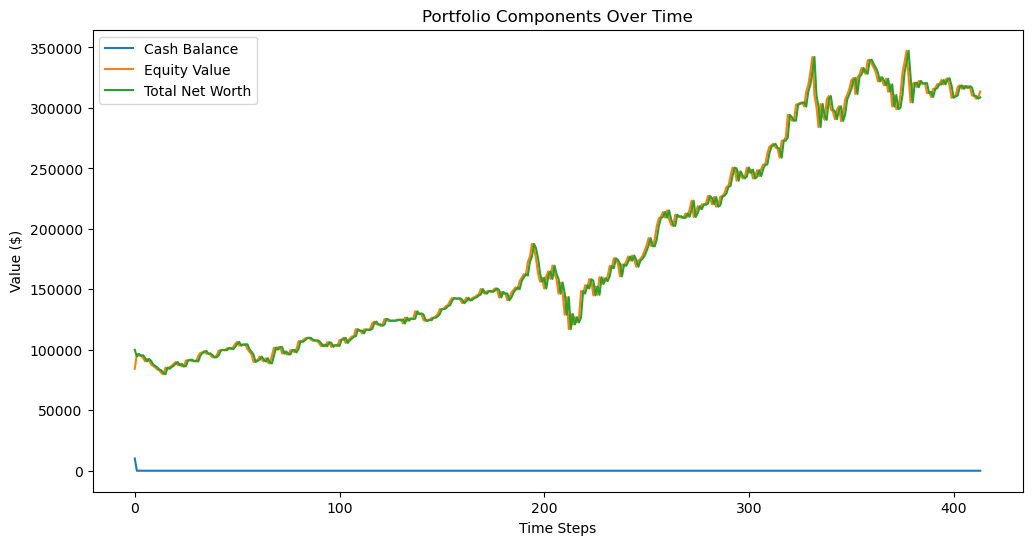

In [12]:
if __name__ == "__main__":
    # Prepare environment and data as before
    # ... [data preparation code] ...

    num_episodes = 100
    max_timesteps = 50000  # Adjust as needed
    log_interval = 10
    device = 'cuda'

    for ticker in STOCKS:
        print(f"\nTraining PPO Continuous agent for {ticker}")
        # Prepare environment
        df_train = train_data[ticker]
        env = TradingEnv(df_train)

        # Determine state and action sizes
        state_size = env.observation_space.shape[0] * env.observation_space.shape[1]
        action_size = env.action_space.shape[0]

        # Initialize PPO agent
        agent = PPOContinuousAgent(state_size=state_size, action_size=action_size, device='cpu')

        # Train agent
        rewards_history = train_ppo_continuous_agent(env, agent, max_timesteps=max_timesteps, log_interval=log_interval)

        # Save the trained model
        torch.save(agent.actor.state_dict(), f'ppo_continuous_actor_{ticker}.pt')
        torch.save(agent.critic.state_dict(), f'ppo_continuous_critic_{ticker}.pt')
        print(f"Trained PPO Continuous agent for {ticker} saved.")

        # Plot training rewards
        plt.figure(figsize=(12,6))
        plt.plot(rewards_history)
        plt.xlabel('Episodes')
        plt.ylabel('Total Reward')
        plt.title(f'PPO Continuous Training Rewards for {ticker}')
        plt.show()

        # Testing the agent on test data
        print(f"\nTesting PPO Continuous agent for {ticker}")
        df_test = test_data[ticker]
        env_test = TradingEnv(df_test)
        agent.actor.eval()
        net_worths, actions, prices, steps, balances, shares_helds = test_ppo_continuous_agent(env_test, agent)

        # Compute equity values
        equity_values = [shares_helds[i] * prices[i] for i in range(len(shares_helds))]

        # Plot test performance
        plot_test_performance_ddpg(net_worths, actions, prices, steps)  # Use the same function as DDPG
        compute_performance_metrics(net_worths)
        plot_cumulative_returns(net_worths, env_test)
        plot_portfolio_components(net_worths, balances, equity_values)
